In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path

In [15]:
p = Path("./images")
data_dir = p
print(data_dir)
print(type(data_dir))
image_count = len(list(p.glob("*.jpg")))
print(image_count)

images
<class 'pathlib.PosixPath'>
196


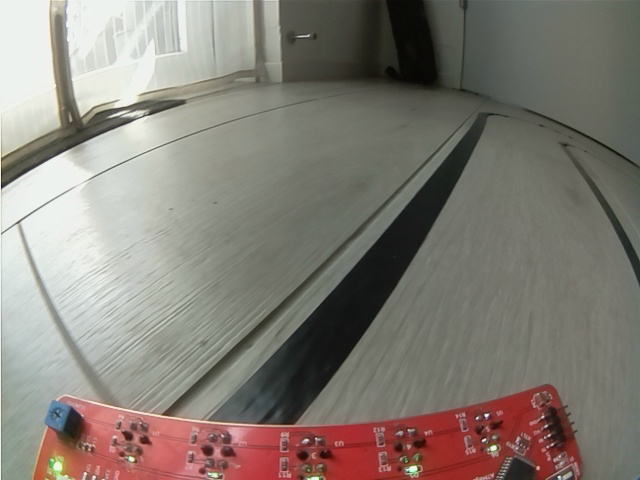

In [22]:
images = list(p.glob("*.jpg"))
PIL.Image.open(str(images[2]))

In [20]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)


Found 0 files belonging to 0 classes.


TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.